# Problem 2: MNIST: Hand-written digit classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import tensorflow as tf

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
type(train_dataset[0][0])

torch.Tensor

We can convert images to numpy arrays and plot them with matplotlib:

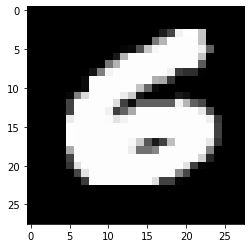

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Example linear model
Let's instantiate a linear model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # For fully-connected networks, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 10),
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


## Training and validation

Now let's try to train the linear model as an example.

In [ ]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

    # We could write our training procedure manually and directly index the `Dataset` objects,
    # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    print("Running epochs...")
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

Running epochs...
Epoch 1/10
Train Epoch: 1  Average loss: 0.0156
Valid set: Average loss: 0.0108, Accuracy: 10859/12000 (90.4917)

Epoch 2/10
Train Epoch: 2  Average loss: 0.0097
Valid set: Average loss: 0.0099, Accuracy: 10935/12000 (91.1250)

Epoch 3/10
Train Epoch: 3  Average loss: 0.0089
Valid set: Average loss: 0.0095, Accuracy: 10952/12000 (91.2667)

Epoch 4/10
Train Epoch: 4  Average loss: 0.0085
Valid set: Average loss: 0.0094, Accuracy: 11002/12000 (91.6833)

Epoch 5/10
Train Epoch: 5  Average loss: 0.0083
Valid set: Average loss: 0.0093, Accuracy: 11011/12000 (91.7583)

Epoch 6/10
Train Epoch: 6  Average loss: 0.0081
Valid set: Average loss: 0.0093, Accuracy: 11034/12000 (91.9500)

Epoch 7/10
Train Epoch: 7  Average loss: 0.0080
Valid set: Average loss: 0.0092, Accuracy: 11043/12000 (92.0250)

Epoch 8/10
Train Epoch: 8  Average loss: 0.0079
Valid set: Average loss: 0.0093, Accuracy: 11025/12000 (91.8750)

Epoch 9/10
Train Epoch: 9  Average loss: 0.0078
Valid set: Average los

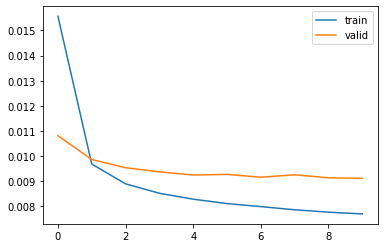

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

## Testing
After selecting hyperparameters from the validation set, evaluate on the held-out test set (distinct from the validation set).

In [ ]:
def test_performance(model, batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

In [ ]:
test_performance(model)

Test set: Average loss: 0.0083, Accuracy: 9275/10000 (92.7500)


(0.008280813763663172, 0.9275)

Not bad! Even the linear model gets above 92% accuracy.

## Visualizing predictions

We can visualize and inspect the model predictions. Here is an example of how to visualize the wrongly classified cases among the first 20 validation examples.

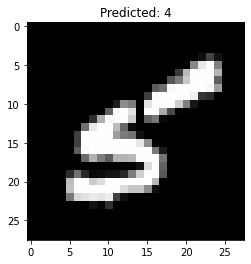

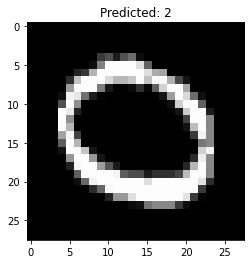

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

# Turning off automatic differentiation
with torch.no_grad():
      for i in range(20):
        data, target = valid_dataset[i]
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        if pred.item() != target:
            plt.imshow(data[0].numpy(), cmap='gray')
            plt.title(f'Predicted: {pred.item()}')
            plt.show()

## Your code: 2 (b)

First try. Clearly too unstable.

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),

    nn.Dropout(p=0.12),
    nn.Linear(784, 95),
    nn.ReLU(),

    nn.Linear(95,10),
    nn.Linear(10,95),
    #nn.Dropout(p=0.12),
    nn.ReLU(),
    
    nn.Linear(95,10),
    nn.Softmax(),
)


# My code: 2 (b)

Another try with references:
* https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ 

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),

    nn.Dropout(p=0.2),
    nn.ReLU(),

    nn.Linear(784, 140),
    #nn.Dropout(p=0.6),
    nn.ReLU(),

    nn.Linear(140,60),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    
    nn.Linear(60,10),
    #nn.Dropout(p=0.12),
    nn.Softmax(),
)

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),

    nn.Dropout(p=0.2),
    nn.Linear(784, 90),
    nn.ReLU(),

    nn.Linear(90,10),
    nn.Linear(10,90),
    nn.ReLU(),
    
    nn.Linear(90,10),
)


Iteration:  23
Running epochs...
Epoch 1/10
Train Epoch: 1  Average loss: 0.0124
Valid set: Average loss: 0.0064, Accuracy: 11251/12000 (93.7583)

Epoch 2/10
Train Epoch: 2  Average loss: 0.0059
Valid set: Average loss: 0.0048, Accuracy: 11457/12000 (95.4750)

Epoch 3/10
Train Epoch: 3  Average loss: 0.0046
Valid set: Average loss: 0.0041, Accuracy: 11519/12000 (95.9917)

Epoch 4/10
Train Epoch: 4  Average loss: 0.0038
Valid set: Average loss: 0.0039, Accuracy: 11578/12000 (96.4833)

Epoch 5/10
Train Epoch: 5  Average loss: 0.0032
Valid set: Average loss: 0.0032, Accuracy: 11649/12000 (97.0750)

Epoch 6/10
Train Epoch: 6  Average loss: 0.0029
Valid set: Average loss: 0.0031, Accuracy: 11651/12000 (97.0917)

Epoch 7/10
Train Epoch: 7  Average loss: 0.0026
Valid set: Average loss: 0.0031, Accuracy: 11638/12000 (96.9833)

Epoch 8/10
Train Epoch: 8  Average loss: 0.0024
Valid set: Average loss: 0.0033, Accuracy: 11650/12000 (97.0833)

Epoch 9/10
Train Epoch: 9  Average loss: 0.0022
Valid s

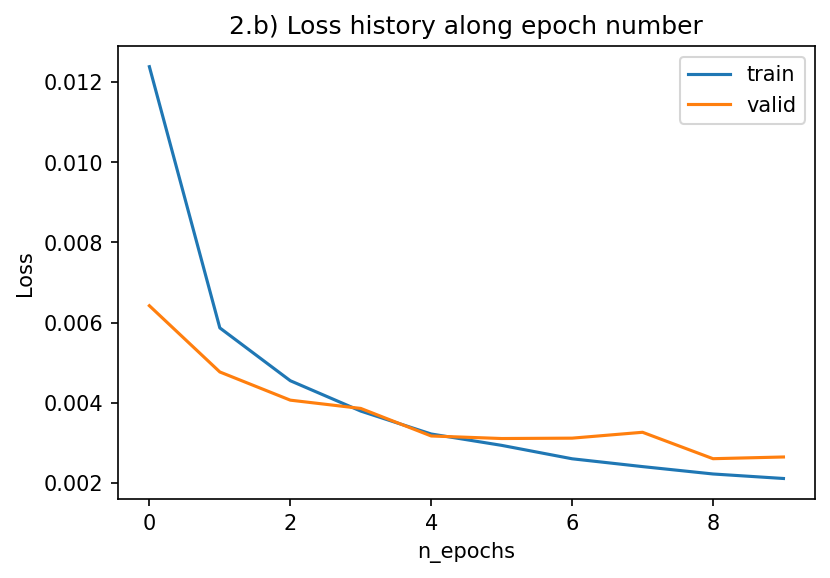

Test set: Average loss: 0.0027, Accuracy: 9766/10000 (97.6600)


(0.002650090422600624, 0.9766)

In [ ]:
batch_size=32
n_epochs=10

print("Iteration: ",batch_size-9)
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model,batch_size, n_epochs, lr=1e-3)
plt.figure(dpi=150)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.xlabel("n_epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"2.b) Loss history along epoch number")
plt.show()
test_performance(model,batch_size)

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

# Turning off automatic differentiation
mispredictions = 0
with torch.no_grad():
      for i in range(20):
        data, target = valid_dataset[i]
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        if pred.item() != target:
            plt.imshow(data[0].numpy(), cmap='gray')
            plt.title(f'Predicted: {pred.item()}')
            plt.show()
            mispredictions+=1

if mispredictions == 0:
  print("No mispredictions!")
else:
  print("# of mispredictions:\t",mispredictions)

# Example code for convolutional neural networks

In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(8,8)),
    nn.ReLU(),
    nn.MaxPool2d(8),
    nn.Dropout(p=0.5),
    
    nn.Flatten(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)


# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

## Your code: 2 (c)

A first trial

In [ ]:
model = nn.Sequential(
    nn.Conv2d(2, 8, kernel_size=(3,3)),
    nn.MaxPool2d(2),
    
    nn.Conv2d(8, 16, kernel_size=(3,3)),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(400, 118),
    nn.Linear(118, 10),

)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

# make sure the # of parameters is under 50,000
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

# My code: 2(c)

This one is largely inspired from: 
* https://www.kaggle.com/loveall/digit-recognizer-using-cnn-99-accuracy
* https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
* https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392
* https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/


In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=5,stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 32, kernel_size=5,stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(32),

    nn.Flatten(),
    nn.Dropout(p=0.8),
    nn.Linear(4*4*32,10),

)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

# make sure the # of parameters is under 50,000
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([10, 512])
torch.Size([10])
total params: 18474


Running epochs...
Epoch 1/10
Train Epoch: 1  Average loss: 0.0050
Valid set: Average loss: 0.0020, Accuracy: 11760/12000 (98.0000)

Epoch 2/10
Train Epoch: 2  Average loss: 0.0023
Valid set: Average loss: 0.0015, Accuracy: 11829/12000 (98.5750)

Epoch 3/10
Train Epoch: 3  Average loss: 0.0019
Valid set: Average loss: 0.0017, Accuracy: 11806/12000 (98.3833)

Epoch 4/10
Train Epoch: 4  Average loss: 0.0017
Valid set: Average loss: 0.0012, Accuracy: 11867/12000 (98.8917)

Epoch 5/10
Train Epoch: 5  Average loss: 0.0015
Valid set: Average loss: 0.0011, Accuracy: 11869/12000 (98.9083)

Epoch 6/10
Train Epoch: 6  Average loss: 0.0014
Valid set: Average loss: 0.0012, Accuracy: 11880/12000 (99.0000)

Epoch 7/10
Train Epoch: 7  Average loss: 0.0014
Valid set: Average loss: 0.0012, Accuracy: 11872/12000 (98.9333)

Epoch 8/10
Train Epoch: 8  Average loss: 0.0013
Valid set: Average loss: 0.0011, Accuracy: 11880/12000 (99.0000)

Epoch 9/10
Train Epoch: 9  Average loss: 0.0011
Valid set: Average los

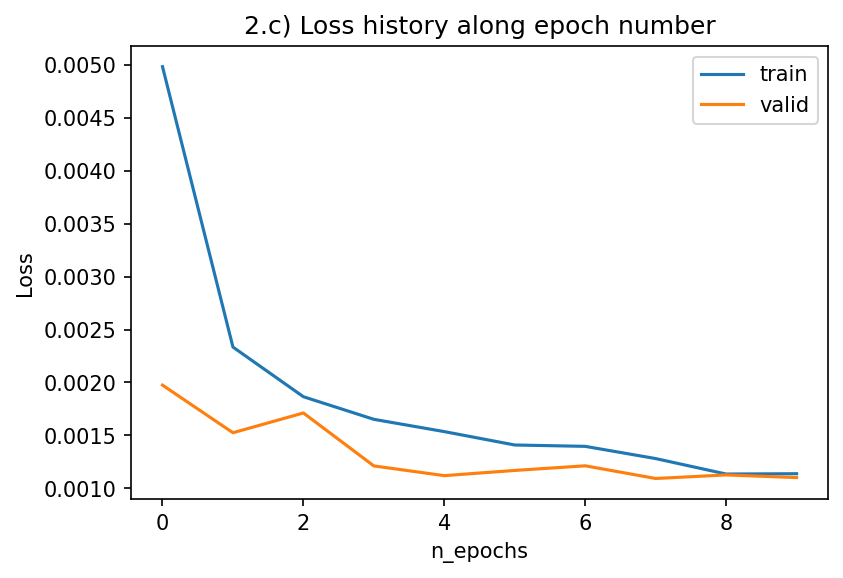

Test set: Average loss: 0.0009, Accuracy: 9905/10000 (99.0500)


(0.000864659142331584, 0.9905)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.figure(dpi=150)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.xlabel("n_epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"2.c) Loss history along epoch number")
plt.show()

test_performance(model)

# Problem 3: Vision Transformer

In [ ]:
!pip install einops

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

## Your code: 3(a)

Implement single-head attention.

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, inner_dim, dropout = 0.):
        super().__init__()
        self.softm = nn.Softmax()
        self.drop = nn.Dropout(dropout)

        self.dk = (1/inner_dim)**0.5
        self.query = nn.Linear(input_dim,inner_dim,bias=False)
        self.key = nn.Linear(input_dim,inner_dim,bias=False)
        self.value = nn.Linear(input_dim,inner_dim,bias=False)

    def forward(self,x):
        Q = self.query(x)
        K = self.key(x)
        KT = torch.transpose(K, 1, 2)
        V = self.value(x)

        out = torch.matmul(Q,KT)
        out = torch.mul(out,self.dk)
        out = self.softm(out)
        out = torch.matmul(out,V)
        return out

Test the following multihead attention implementation that relies on the single-head attention implementation above.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        self.attention_heads = nn.ModuleList([
            SingleHeadAttention(dim, dim_head, dropout=dropout)
            for _ in range(heads)
        ])

    def forward(self, x):
        out = torch.cat([
            head(x) for head in self.attention_heads
        ], dim=-1)
        return out

Test code for multihead attention:

In [ ]:
T = 5
input_dim = 32
batch_size = 20

heads = 8
dim_head = 64

test_input = torch.zeros((batch_size, T, input_dim))

test_attention_module = Attention(input_dim)
test_output = test_attention_module(test_input)

print(test_output.shape)
assert test_output.size() == (batch_size, T, heads * dim_head), "Shapes are incorrect"

torch.Size([20, 5, 512])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Your code: 3 (b)

In [ ]:
class ViTLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()

        self.query = dim
        self.batch = 32
        self.p = dropout

        self.attn = nn.Sequential(
            torch.nn.LayerNorm(dim), # [self.batch, 2*heads+1,self.query]
            Attention(self.query, heads, dim_head, dropout = self.p),
            nn.Dropout(p=self.p),
            #nn.Softmax(),
        )
        self.feedforward = nn.Sequential(
            torch.nn.LayerNorm(dim), # [self.batch, 2*heads+1,self.query]
            nn.Linear(self.query,mlp_dim),
            #nn.Dropout(p=dropout),
            nn.Linear(mlp_dim,self.query),
            nn.Dropout(p=self.p),
            nn.Softmax(),
        )

        self.A_att = nn.Linear(self.query*heads,dim_head)
        self.B_att = nn.Linear(dim_head,self.query)

        self.A_forw = nn.Linear(self.query,dim_head)
        self.B_forw = nn.Linear(dim_head,self.query)

    def forward(self, x):
        # print("Entry...",x.shape)
        
        y = self.attn(x)
        # print("Attention...",y.shape)
        
        y = F.relu(self.A_att(y))
        y = self.B_att(y)
        # print("Residual connection...",y.shape)
        x = x+y

        # print("Feed-forwarding...")
        y = self.feedforward(x)
        
        y = F.relu(self.A_forw(y))
        y = self.B_forw(y)

        # print("Residual connection...")
        x = x+y


        return x

## ViT code for 3 (c)

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128, 
                 dim_head = 64,
                 dropout = 0., emb_dropout = 0.):
        super().__init__()

        image_height, image_width = 28, 28
        num_classes = 10
        channels = 1

        patch_height = patch_size
        patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, (
            'Image dimensions must be divisible by the patch size.')

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        # print("Patch dim: ",patch_dim)

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.Sequential(*nn.ModuleList([
            ViTLayer(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)                       
        ]))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        #print("Image shape: ",img.shape)
        x = self.to_patch_embedding(img)
        #print("Patch embedding shape: ",x.shape)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.emb_dropout(x)

        
        x = self.transformer(x)

        x = x[:, 0]
        # print("Output shape: ",x.shape)
        return self.mlp_head(x)

In [ ]:
model = ViT(patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Running epochs...
Epoch 1/10
Train Epoch: 1  Average loss: 0.0103
Valid set: Average loss: 0.0059, Accuracy: 11286/12000 (94.0500)

Epoch 2/10
Train Epoch: 2  Average loss: 0.0045
Valid set: Average loss: 0.0039, Accuracy: 11547/12000 (96.2250)

Epoch 3/10
Train Epoch: 3  Average loss: 0.0038
Valid set: Average loss: 0.0038, Accuracy: 11557/12000 (96.3083)

Epoch 4/10
Train Epoch: 4  Average loss: 0.0033
Valid set: Average loss: 0.0038, Accuracy: 11524/12000 (96.0333)

Epoch 5/10
Train Epoch: 5  Average loss: 0.0029
Valid set: Average loss: 0.0035, Accuracy: 11577/12000 (96.4750)

Epoch 6/10
Train Epoch: 6  Average loss: 0.0026
Valid set: Average loss: 0.0033, Accuracy: 11619/12000 (96.8250)

Epoch 7/10
Train Epoch: 7  Average loss: 0.0024
Valid set: Average loss: 0.0031, Accuracy: 11640/12000 (97.0000)

Epoch 8/10
Train Epoch: 8  Average loss: 0.0022
Valid set: Average loss: 0.0037, Accuracy: 11578/12000 (96.4833)

Epoch 9/10
Train Epoch: 9  Average loss: 0.0021
Valid set: Average los

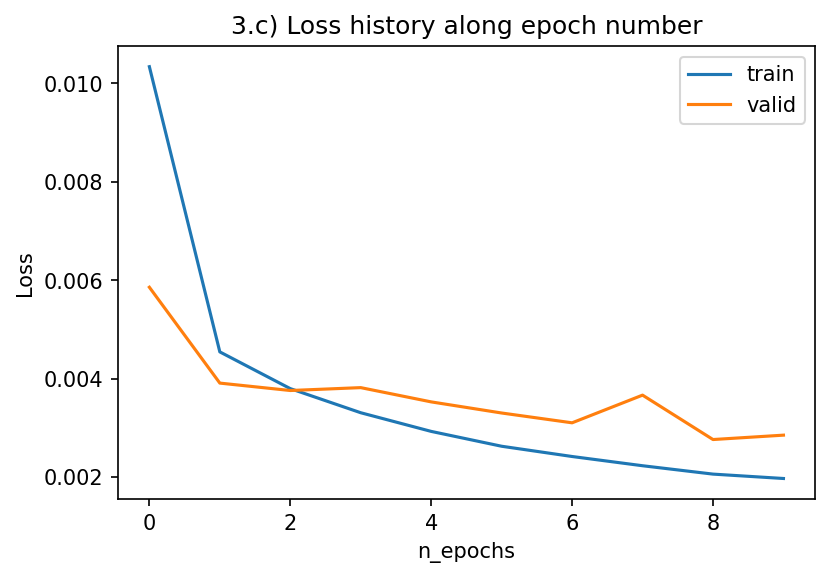

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test set: Average loss: 0.0027, Accuracy: 9727/10000 (97.2700)


(0.0027446756240678953, 0.9727)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.figure(dpi=150)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.xlabel("n_epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"3.c) Loss history along epoch number")
plt.show()

test_performance(model)

(row,colmun) = (0,0)
(row,colmun) = (0,1)
(row,colmun) = (0,2)
(row,colmun) = (0,3)
(row,colmun) = (1,0)
(row,colmun) = (1,1)
(row,colmun) = (1,2)
(row,colmun) = (1,3)


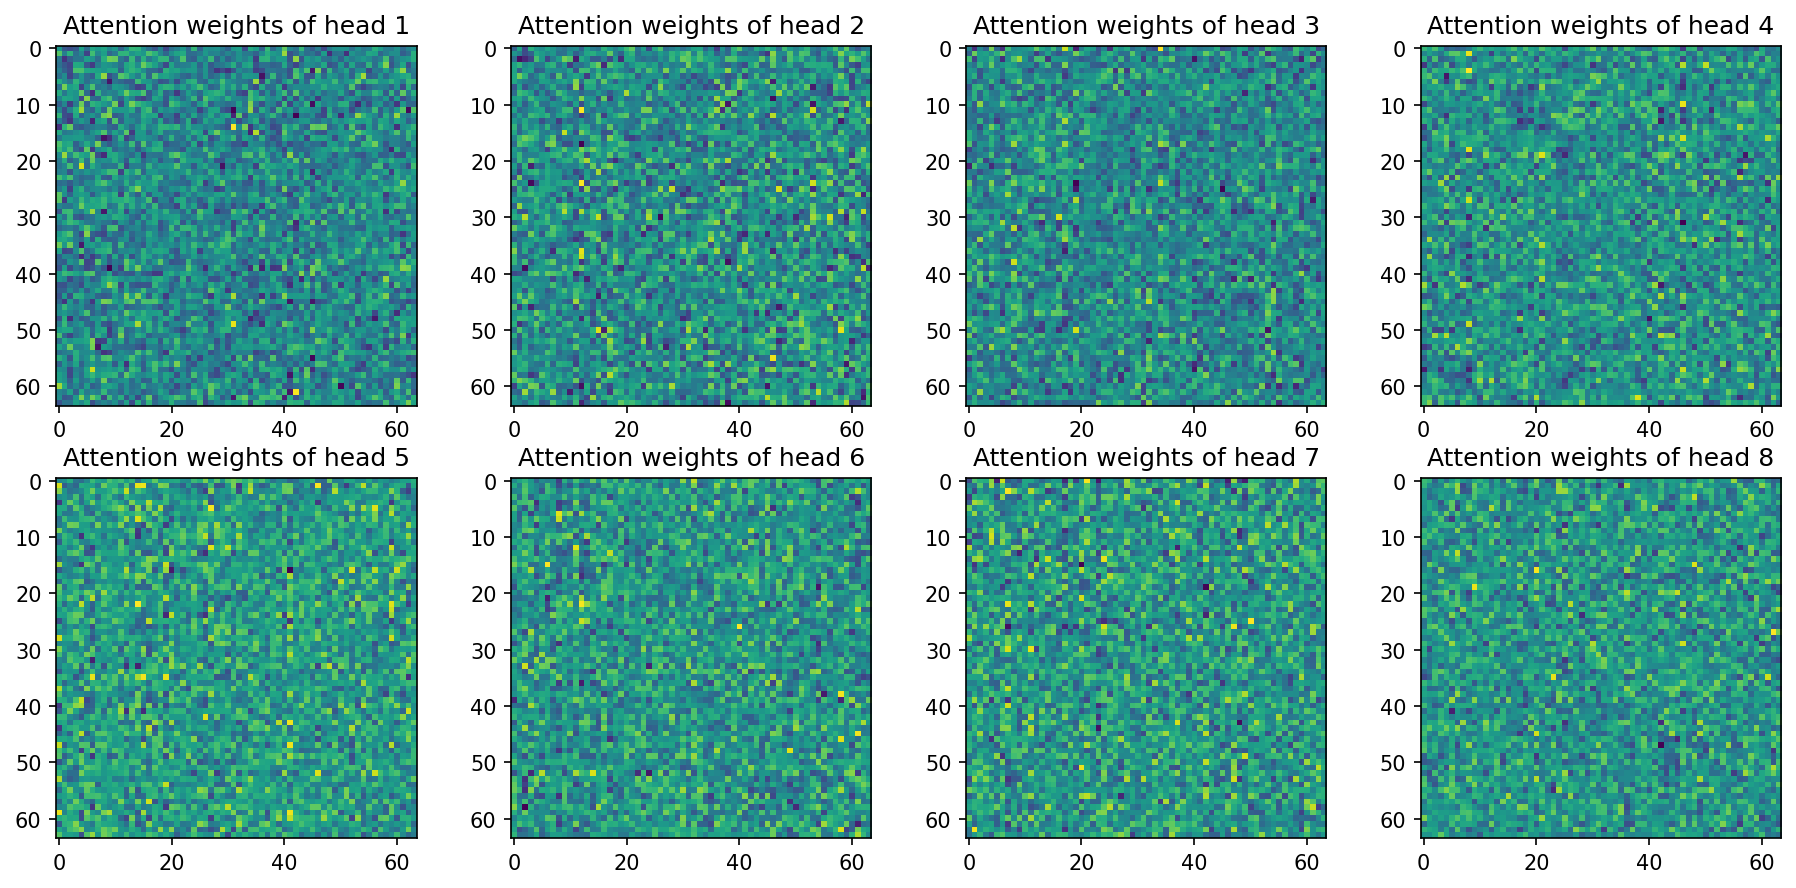

In [ ]:
#print(model.named_parameters)
k=-1

def binary(integer):
  bin = format(integer,"b")
  subplot_list = [1,1,1]
  length = len(bin)
  while length<3:
    bin = '0'+bin
    length = len(bin)
  subplot_str = ''
  for elt in range(len(subplot_list)):
    subplot_list[elt] += int(bin[elt])
    subplot_str = subplot_str + str(subplot_list[elt])
  return(subplot_str)

fig, axes = plt.subplots(nrows=2,ncols=4,dpi=150)
fig.set_figheight(7)
fig.set_figwidth(15)
for j in range(8):
  if j<4: row = 0
  else : row = 1
  col = j - row*4
  print(f"(row,colmun) = ({row},{col})")
  a = model.transformer[k].attn[1].attention_heads[j].value.weight
  b = a.data.numpy()
  axes[row,col].set_title(f"Attention weights of head {j+1}")
  axes[row,col].imshow(b)
fig.show()

#test_performance(model)

In [ ]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=64, bias=True)
  )
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): ViTLayer(
      (attn): Sequential(
        (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (1): Attention(
          (attention_heads): ModuleList(
            (0): SingleHeadAttention(
              (softm): Softmax(dim=None)
              (drop): Dropout(p=0.0, inplace=False)
              (query): Linear(in_features=64, out_features=64, bias=False)
              (key): Linear(in_features=64, out_features=64, bias=False)
              (value): Linear(in_features=64, out_features=64, bias=False)
            )
            (1): SingleHeadAttention(
              (softm): Softmax(dim=None)
              (drop): Dropout(p=0.0, inplace=False)
              (query): Linear(in_features=64, out_features=64, bias=Fal